# Topic Modeling (Working Script)
## Importing Packages and Pre-Processing

In [1]:
import pandas as pd
import spacy
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel
from gensim.models.nmf import Nmf
import pyLDAvis.gensim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Loading cleaned version of the data set
DF = pd.read_csv('Data/CleanedTweets.csv')

DF.head()

,Datetime,TweetID,FullText,UserName,Lang
0,2020-03-02 01:07:24+00:00,1234284135386095616,John Lewis leading marchers across the Edmund ...,Amy Klobuchar,en
1,2020-03-02 00:56:17+00:00,1234281337776955392,Pete Buttigieg has run an inspiring and histor...,Amy Klobuchar,en
2,2020-03-02 00:28:06+00:00,1234274246500720640,"Today, we walked hand-in-hand across the Edmun...",Amy Klobuchar,en
3,2020-03-01 20:01:05+00:00,1234207050034491392,One way we can make sure kids get a good start...,Amy Klobuchar,en
4,2020-03-01 17:30:05+00:00,1234169049573134337,"13 newspapers, from coast to coast and north t...",Amy Klobuchar,en


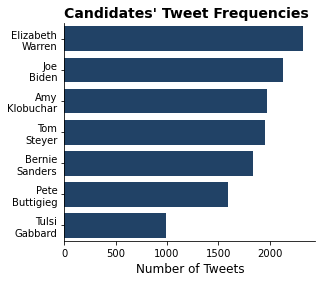

In [49]:
# Plotting the number of tweets for each candidate
candidate_order = DF['UserName'].value_counts().index

fig, ax = plt.subplots(figsize = (4.5,4))
fig.patch.set_facecolor('white')
sns.countplot(y='UserName', data=DF, color='#154172', ax=ax,
              order=candidate_order)
ax.set_xlabel('Number of Tweets', fontsize = 12)
ax.set_ylabel(None)
ax.set_yticklabels(('Elizabeth\nWarren', 'Joe\nBiden',
                    'Amy\nKlobuchar', 'Tom\nSteyer',
                    'Bernie\nSanders', 'Pete\nButtigieg',
                    'Tulsi\nGabbard'))
ax.set_title("Candidates' Tweet Frequencies", 
             loc = 'left', fontweight = 'semibold', fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [3]:
# Loading spacy
nlp = spacy.load("en_core_web_sm", parser = False)

## load the current list of prefixes & remove # from the list 
## (keep hastags in tact)
prefixes = list(nlp.Defaults.prefixes)
prefixes.remove('#')

## recompile a new prefix regex with the smaller list of prefixes
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
## set the tokenizer prefix_search to use the search of the newly compiled regex
nlp.tokenizer.prefix_search = prefix_regex.search

In [4]:
# Defining function that will remove unwanted tokens. It is a bit different from
# the function used in authorship detection, since we want to remove stop words
# but keep hashtags and mentions
# (stop words can be useful to identify authors, but will clutter up the topics)

def keepChars(tweet):
    '''
    Cleans an invididual tweet by removing non-character features, any url link, 
    etc. Designed to be used with a map function.
    Input: tweet (list of tokens)
    Output: charTweet (list of tokens)
    '''
    ## initialize a list to store the characters only
    charTweet = []
    
    for token in tweet:
        ## remove token if it contains a url link
        if 'http' in token.text:
            continue
        
        ## remove token if it is 'amp'
        if token.text == 'amp':
            continue
        
        ## remove token if it is punctuation, stop word, or space
        if token.is_punct or token.is_stop or token.is_space:
            continue
        
        ## remove token if it is less than one character long
        elif len(token.text) < 2:
            continue
        
        ## append the new lemmatized and lowered token to the character only token list
        else:
            charTweet.append(token.lemma_.lower())
        
    return charTweet

In [5]:
## tokenize every tweet in the dataframe & adding a new column in the process
DF['Tokens'] = DF['FullText'].apply(lambda x: nlp.tokenizer(x))
DF['TextOnly'] = DF['Tokens'].map(keepChars)

DF.head()

,Datetime,TweetID,FullText,UserName,Lang,Tokens,TextOnly
0,2020-03-02 01:07:24+00:00,1234284135386095616,John Lewis leading marchers across the Edmund ...,Amy Klobuchar,en,"(John, Lewis, leading, marchers, across, the, ...","[john, lewis, lead, marcher, edmund, pettus, b..."
1,2020-03-02 00:56:17+00:00,1234281337776955392,Pete Buttigieg has run an inspiring and histor...,Amy Klobuchar,en,"(Pete, Buttigieg, has, run, an, inspiring, and...","[pete, buttigieg, run, inspire, historic, camp..."
2,2020-03-02 00:28:06+00:00,1234274246500720640,"Today, we walked hand-in-hand across the Edmun...",Amy Klobuchar,en,"(Today, ,, we, walked, hand, -, in, -, hand, a...","[today, walk, hand, hand, edmund, pettus, brid..."
3,2020-03-01 20:01:05+00:00,1234207050034491392,One way we can make sure kids get a good start...,Amy Klobuchar,en,"(One, way, we, can, make, sure, kids, get, a, ...","[way, sure, kid, good, start, roof, head, stab..."
4,2020-03-01 17:30:05+00:00,1234169049573134337,"13 newspapers, from coast to coast and north t...",Amy Klobuchar,en,"(13, newspapers, ,, from, coast, to, coast, an...","[13, newspaper, coast, coast, north, south, en..."


## LDA

In [6]:
# Changing pandas series to list of lists for gensim LDA
texts = list(DF['TextOnly'])

# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Gensim LDA stores all the text for processing into a corpus object. 
# All text is filtered through the previously constructed dictionary.
corpus = [dictionary.doc2bow(text) for text in texts]

In [8]:
# For this first example, I'm going to choose 8 topics to see how it's working,
# even though that may not be the best choice.
total_topics = 8

# Experiment with the alpha assingment to investigate alpha parameter settings on topic assignments
#lda_alpha = 'auto' #learns asymmetic prior from the corpus
lda_alpha = 'symmetric'
#lda_alpha = 'asymmetric'  # sets alpha = 1 / number_of_topics

lda1 = models.LdaModel(corpus,
                       id2word = dictionary,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha=lda_alpha,
                       random_state=1)

In [9]:
#Show first n=10 important words in the topics:
topics = lda1.show_topics(total_topics, 10)

for topic in topics:
    topic_num = topic[0]
    topic_tokens = topic[1]
    print(f'Topic {topic_num}')
    print(f'{topic_tokens}\n')

Topic 0
0.019*"debate" + 0.018*"help" + 0.014*"day" + 0.013*"tulsi" + 0.013*"thank" + 0.012*"donor" + 0.010*"let" + 0.010*"tonight" + 0.009*"need" + 0.009*"donate"

Topic 1
0.038*"trump" + 0.024*"american" + 0.020*"president" + 0.019*"war" + 0.014*"donald" + 0.011*"people" + 0.011*"end" + 0.008*"need" + 0.008*"policy" + 0.008*"care"

Topic 2
0.016*"thank" + 0.013*"work" + 0.012*"stand" + 0.012*"fight" + 0.011*"worker" + 0.010*"family" + 0.009*"service" + 0.009*"support" + 0.009*"wage" + 0.009*"country"

Topic 3
0.030*"war" + 0.024*"#tulsi2020" + 0.021*"new" + 0.012*"troop" + 0.009*"right" + 0.009*"american" + 0.009*"iraq" + 0.008*"military" + 0.007*"iran" + 0.007*"protect"

Topic 4
0.017*"country" + 0.012*"people" + 0.011*"work" + 0.010*"president" + 0.010*"need" + 0.009*"world" + 0.009*"america" + 0.007*"well" + 0.007*"year" + 0.007*"government"

Topic 5
0.023*"people" + 0.016*"tulsi" + 0.015*"american" + 0.015*"#tulsi2020" + 0.014*"live" + 0.012*"country" + 0.012*"president" + 0.010*

From the above lists of words, we see some topics forming like:

    3. War in the Middle East
    5. Tulsi Gabbard
    6. Climate change

However, other topics are harder to discern and use a lot of general political words like "people", "country", "american", and "president".
I'm going to remove those and then try different numbers of topics.

In [7]:
# Removing some general political words
remove_list = ["people", "country", "american", "america", "president", "thank"]
texts_rm = [[token for token in tweet if token not in remove_list] for tweet in texts] 

# Create dictionary
dictionary_rm = corpora.Dictionary(texts_rm)

# Gensim LDA stores all the text for processing into a corpus object. 
# All text is filtered through the previously constructed dictionary.
corpus_rm = [dictionary_rm.doc2bow(text) for text in texts_rm]

In [11]:
# Tuning hyperparameters (number of topics, alpha):
# Looking for the model with minimum perplexity and maximium topic coherence.

### This takes a while to run!

perplexity_lda = []
coherence_lda = []
topic_count_lda = []
alpha_options = ['auto', 'symmetric', 'asymmetric']
alpha_option_lda = []

for num_topics in range(5, 21, 1):
    for lda_alpha in alpha_options:

        print(f"Computing the lda model using {num_topics} topics and {lda_alpha} alpha.")

        topic_lda = models.LdaModel(corpus_rm,
                                    id2word = dictionary_rm,
                                    num_topics = num_topics,
                                    iterations = 1000,
                                    alpha = lda_alpha,
                                    random_state=1)

        topic_count_lda.append(num_topics)
        
        alpha_option_lda.append(lda_alpha)

        # a measure of how good the model is. lower the better.
        perplexity_lda.append(topic_lda.log_perplexity(corpus_rm))

        # Compute Coherence Score
        cm = CoherenceModel(model=topic_lda, corpus=corpus_rm, dictionary=dictionary_rm, coherence='u_mass')
        coherence_lda.append(cm.get_coherence())

Computing the lda model using 5 topics and auto alpha.
Computing the lda model using 5 topics and symmetric alpha.
Computing the lda model using 5 topics and asymmetric alpha.
Computing the lda model using 6 topics and auto alpha.
Computing the lda model using 6 topics and symmetric alpha.
Computing the lda model using 6 topics and asymmetric alpha.
Computing the lda model using 7 topics and auto alpha.
Computing the lda model using 7 topics and symmetric alpha.
Computing the lda model using 7 topics and asymmetric alpha.
Computing the lda model using 8 topics and auto alpha.
Computing the lda model using 8 topics and symmetric alpha.
Computing the lda model using 8 topics and asymmetric alpha.
Computing the lda model using 9 topics and auto alpha.
Computing the lda model using 9 topics and symmetric alpha.
Computing the lda model using 9 topics and asymmetric alpha.
Computing the lda model using 10 topics and auto alpha.
Computing the lda model using 10 topics and symmetric alpha.
Com

In [12]:
### Creating a dataframe to plot perplexity and coherence

# Create a list that combines the number of topics with the alpha option
model_type = [i+', '+j for i, j in zip([str(k) for k in topic_count_lda], [m[0:4] for m in alpha_option_lda])] 

# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'num_topics':topic_count_lda,
                           'alpha':alpha_option_lda,
                           'perplexity': perplexity_lda,
                           'coherence': coherence_lda,
                          'model_type': model_type}
                         )

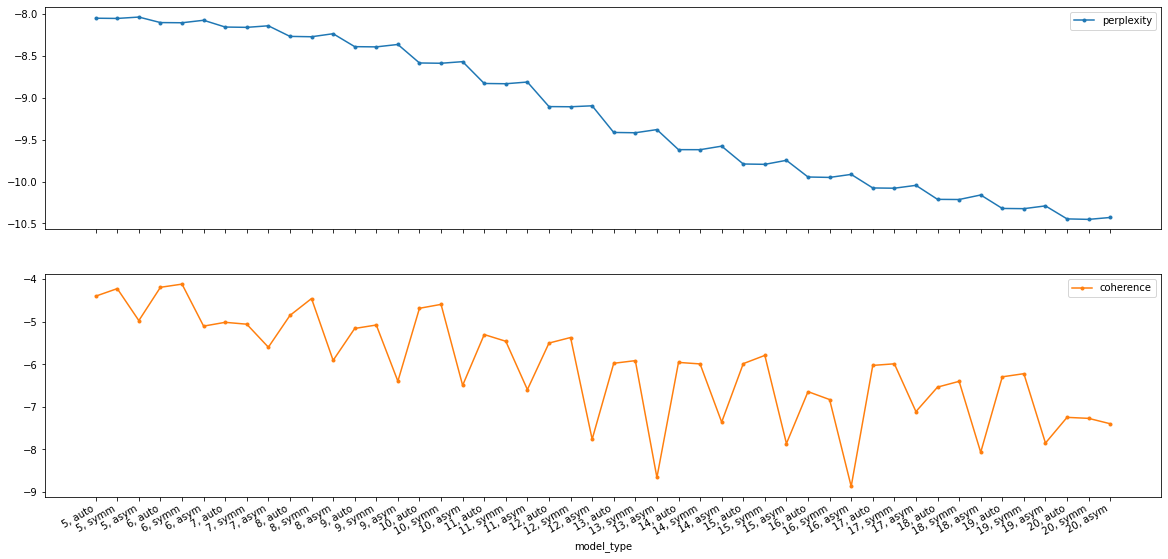

In [13]:
# Graphing perplexity and topic coherence for every model type
topics_lda.plot.line(x='model_type', y=['perplexity', 'coherence'],
                             marker='.', subplots = True, figsize=(20,10))
plt.xticks(range(len(topics_lda.model_type)), topics_lda.model_type)
plt.show()

From the above plot, we can see that perplexity and coherence both decrease as the number of topics increases. We want a low perplexity but a high coherence, so we will have to balance the two.

Here are three models that we will investigate further:

1. Model with `num_topics = 6` and `alpha = symmetric` (highest topic coherence, but high perplexity)
2. Model with `num_topics = 10` and `alpha = symmetric` (higher coherence than surrounding models, slightly lower perplexity)
3. Model with `num_topics = 17` and `alpha = auto` (higher coherence than surroundng models, fairly low perplexity)

After looking over the top 25 words for each model, we will (subjectively) choose which seemed the best.

In [14]:
# Model 1: 6 topics, symmetric alpha

total_topics = 6
lda_alpha = 'symmetric'

lda1 = models.LdaModel(corpus_rm,
                       id2word = dictionary_rm,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha = lda_alpha,
                       random_state = 1)


## Uncomment for fancy viz, but the topic numbers do not match lda.show_topics() 
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.gensim.prepare(lda1, corpus_rm, dictionary_rm, mds='tsne')
#panel


#Show first n=25 important words in the topics:
topics = lda1.show_topics(total_topics, 25, formatted=False)


for index, topic in topics:
    tokens = [w[0] for w in topic]
    print(f'Topic {index}\n{tokens}\n')

Topic 0
['right', 'year', 'fight', 'policy', 'justice', 'today', 'act', 'stand', 'work', 'trump', 'serve', 'system', 'need', 'criminal', 'freedom', 'administration', 'government', 'day', 'plan', 'woman', 'climate', 'deserve', 'human', 'crisis', 'protect']

Topic 1
['time', 'help', 'debate', 'need', 'donor', 'love', 'gun', 'race', 'interest', '--&gt', 'end', 'campaign', '#demdebate', 'donate', 'chip', 'arm', 'reach', '#tulsi2020', 'power', 'movement', 'let', 'stand', 'live', 'politician', 'work']

Topic 2
['war', 'care', 'need', 'health', 'end', '#tulsi2020', '#demdebate', 'change', 'live', 'know', 'corporate', 'future', 'plan', 'fight', 'want', 'world', 'come', 'today', 'day', 'trump', 'climate', 'peace', 'family', 'planet', 'believe']

Topic 3
['new', 'climate', 'change', 'need', 'day', 'big', 'work', 'join', 'let', 'great', 'hampshire', 'iowa', 'win', 'help', 'today', 'build', 'go', 'crisis', 'hall', 'town', 'waste', 'come', 'cold', 'state', 'support']

Topic 4
['trump', 'war', 'dona

Here's my generalizations of the LDA Model 1 topics:
- Topic 0: Human Rights - Criminal Justice - Climate Change
- Topic 1: Donate - Debate
- Topic 2: War - Health Care - Climate Change
- Topic 3: Climate Change - Campaigning in Iowa and New Hampshire
- Topic 4: War in Iran/Iraq
- Topic 5: Tulsi Gabbard

This model doesn't seem great, since multiple Topics (selected by the model) had a range of topics (identified by me). Additionally, 'climate change' showed up in three of the Topics.

In [15]:
# Model 2: 10 topics, symmetric alpha

total_topics = 10
lda_alpha = 'symmetric'

lda2 = models.LdaModel(corpus_rm,
                       id2word = dictionary_rm,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha = lda_alpha,
                       random_state = 1)

## Uncomment for fancy viz, but the topic numbers do not match lda.show_topics() 
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.gensim.prepare(lda1, corpus_rm, dictionary_rm, mds='tsne')
#panel


#Show first n=25 important words in the topics:
topics = lda2.show_topics(total_topics, 25, formatted=False)


for index, topic in topics:
    tokens = [w[0] for w in topic]
    print(f'Topic {index}\n{tokens}\n')

Topic 0
['right', 'regime', 'fight', 'stand', 'trump', 'year', 'corruption', 'human', 'justice', 'policy', 'criminal', 'need', 'today', 'profit', 'immigration', 'power', 'plan', 'system', 'work', 'administration', 'woman', '#demdebate', 'celebrate', 'deserve', 'protect']

Topic 1
['time', 'need', 'peace', 'live', 'wealth', 'powerful', 'nation', 'stand', 'color', 'work', 'call', 'interest', 'new', 'end', 'wage', 'politician', 'let', 'support', 'century', 'help', 'racism', 'matt', 'hour', 'respect', 'community']

Topic 2
['need', 'care', 'health', 'war', 'end', 'know', '#demdebate', 'climate', 'trump', 'plan', 'iran', 'change', 'power', 'live', 'believe', 'crisis', 'action', 'like', 'world', 'planet', 'day', 'emergency', 'thing', 'year', 'time']

Topic 3
['change', 'climate', 'need', 'work', 'war', 'crisis', 'new', 'big', 'build', 'go', 'support', 'house', 'grateful', 'white', 'trump', 'issue', 'waste', 'community', 'healthcare', 'future', 'leader', 'day', 'party', 'run', 'talk']

Topic 

Here's my generalizations of the LDA Model 2 topics:
- Topic 0: Human Rights - Criminal Justice
- Topic 1: ? General Political Phrases
- Topic 2: Health Care - War - Climate Change
- Topic 3: Climate Change
- Topic 4: Anti-Trump - War
- Topic 5: Education - Military
- Topic 6: Gun Violence - Campaigning in South Carolina
- Topic 7: ? Weird mix of Saudi Arabia, China, and Puerto Rico
- Topic 8: ? General Campaigning Phrases
- Topic 9: Tulsi Gabbard

This model seems slightly worse than Model 1, since a few Topics were hard for me to categorize.

In [16]:
# Model 3: 17 topics, auto alpha

total_topics = 17
lda_alpha = 'auto'

lda3 = models.LdaModel(corpus_rm,
                       id2word = dictionary_rm,
                       num_topics = total_topics,
                       iterations = 1000,
                       alpha = lda_alpha,
                       random_state = 1)


## Uncomment for fancy viz, but the topic numbers do not match lda.show_topics() 
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.gensim.prepare(lda1, corpus_rm, dictionary_rm, mds='tsne')
#panel


#Show first n=25 important words in the topics:
topics = lda3.show_topics(total_topics, 25, formatted=False)


for index, topic in topics:
    tokens = [w[0] for w in topic]
    print(f'Topic {index}\n{tokens}\n')

Topic 0
['war', 'trump', 'cost', 'policy', 'iran', 'family', 'human', 'cold', 'care', 'administration', 'immigration', 'year', 'billion', 'military', 'corruption', 'mean', 'mr.', 'pay', 'need', 'system', 'washington', 'plan', 'deserve', 'medicare', 'rich']

Topic 1
['call', 'help', 'wealth', 'time', 'page', 'need', 'century', 'turn', 'ban', 'act', 'community', 'like', 'congress', 'demand', 'live', 'moral', 'support', 'assault', 'new', 'government', 'lie', '21st', 'million', 'terrible', 'nation']

Topic 2
['need', 'know', 'donor', 'trump', 'debate', 'planet', 'world', 'powerful', 'white', 'long', 'interest', 'go', '9/11', 'qualify', 'corporate', 'value', 'change', 'new', 'house', 'take', 'power', 'future', 'end', 'help', 'wait']

Topic 3
['change', 'climate', 'new', 'need', 'work', 'trump', 'biden', 'house', 'folk', 'policy', 'foreign', 'crisis', 'big', '#demdebate', 'issue', 'hampshire', 'talk', 'soldier', 'go', 'like', 'come', 'middle', 'build', 'joe', 'day']

Topic 4
['trump', 'donal

Here's my generalizations of the LDA Model 3 topics:
- Topic 0: War - Corrpution
- Topic 1: ?
- Topic 2: ?
- Topic 3: Climate Change - Joe Biden
- Topic 4: Trump's Foreign Policy and Corruption
- Topic 5: ? Wide Range of Policy Topics
- Topic 6: Gun Violence - South Carolina
- Topic 7: War/Peace
- Topic 8: Debate - Impeachment
- Topic 9: Campaigning (donation goals, town hall, debate)
- Topic 10: ?
- Topic 11: Climate Change
- Topic 12: Jobs/Economy
- Topic 13: Military
- Topic 14: Health Care - Middle East Topics (nuclear, Iran, Iraq, war)
- Topic 15: General Political Sentiments
- Topic 16: ?

While this model determined some Topics well--9 and 12 were pretty focused on one idea--we couldn't determine any sort of pattern for some of them. I think this is the worst model so far.

So for LDA, Model 1 (6 topics) seems the best. I'm going to try NMF now to see if it does better.

## NMF

In [8]:
# In NNMF factorization we will use term-frequency-inverse_document-frequency for weighting the term document matrix
tfidf = models.TfidfModel(corpus_rm) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus_rm]      # step 2 -- use the model to transform vectors

In [18]:
# Finding NMF model with the highest topic coherence

### This takes a while to run!

coherence_nmf = []
topic_count_nmf = []

for num_topics in range(5, 21, 1):

    print(f"Computing the NMF model using {num_topics} topics")

    nmf = Nmf(corpus_tfidf,
              id2word = dictionary_rm,
              passes = 20,
              num_topics = num_topics,
              random_state = 1)

    topic_count_nmf.append(num_topics)

    # Compute Coherence Score
    cm = CoherenceModel(model=nmf, corpus=corpus_rm, dictionary=dictionary_rm, coherence='u_mass')
    coherence_nmf.append(cm.get_coherence())

Computing the NMF model using 5 topics


C:\Users\nicol\Anaconda3\lib\site-packages\gensim\models\nmf.py:588: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(corpus, collections.Iterator) and self.passes > 1:


Computing the NMF model using 6 topics
Computing the NMF model using 7 topics
Computing the NMF model using 8 topics
Computing the NMF model using 9 topics
Computing the NMF model using 10 topics
Computing the NMF model using 11 topics
Computing the NMF model using 12 topics
Computing the NMF model using 13 topics
Computing the NMF model using 14 topics
Computing the NMF model using 15 topics
Computing the NMF model using 16 topics
Computing the NMF model using 17 topics
Computing the NMF model using 18 topics
Computing the NMF model using 19 topics
Computing the NMF model using 20 topics


In [19]:
### Creating a dataframe to plot coherence

topics_nmf = pd.DataFrame({'num_topics':topic_count_nmf,
                           'coherence': coherence_nmf})

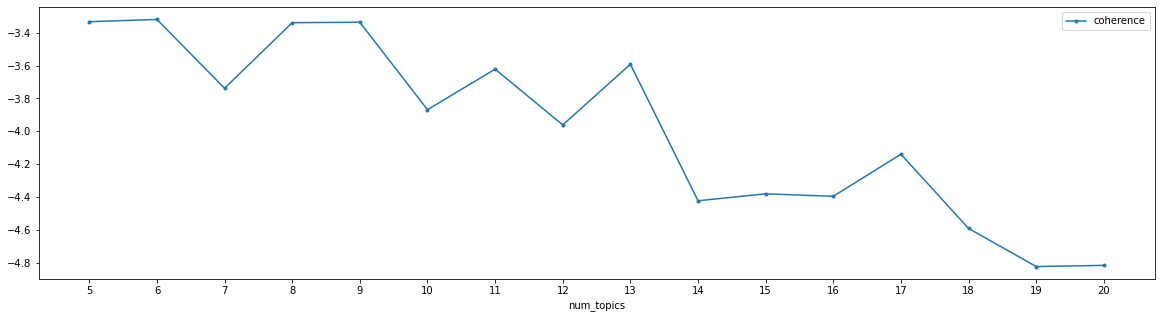

In [20]:
# Graphing topic coherence for every model type
topics_nmf.plot.line(x='num_topics', y='coherence',
                             marker='.', figsize=(20,5))
plt.xticks(range(5,21), topics_nmf.num_topics)
plt.show()

From the above plot, we can see that the models with `num_topics` equal to 5, 6, 8, or 9 have the highest coherence scores. 

I'm going to investigate the following models further, since they align with the LDA models (6 and 10 topics) used earlier.
1. Model with `num_topics=6`
2. Model with `num_topics = 9`

In [9]:
# Model 1: 6 topics

total_topics = 6

nmf1 = Nmf(corpus_tfidf,
              id2word = dictionary_rm,
              passes = 20,
              num_topics = total_topics,
              random_state = 1)

#Show first n=25 important words in the topics:
topics = nmf1.show_topics(total_topics, 25, formatted=False)


for index, topic in topics:
    tokens = [w[0] for w in topic]
    print(f'Topic {index}\n{tokens}\n')

C:\Users\nicol\Anaconda3\lib\site-packages\gensim\models\nmf.py:588: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(corpus, collections.Iterator) and self.passes > 1:


Topic 0
['iowa', 'join', 'day', 'live', 'right', 'come', 'work', 'today', 'fight', 'great', 'caucus', 'new', 'thanks', 'hampshire', 'tulsi', 'town', 'hall', 'let', 'family', 'county', 'time', 'love', 'nation', 'justice', 'friend']

Topic 1
['campaign', 'chip', 'win', 'big', 'help', 'movement', 'grassroots', 'build', 'tonight', 'fight', 'structural', 'donor', 'go', 'debate', 'change', 'need', 'million', 'goal', 'momentum', 'deadline', '#demdebate', 'stage', 'donation', 'fundraising', 'donate']

Topic 2
['care', 'health', 'need', 'plan', 'climate', 'change', 'medicare', 'fight', 'affordable', 'right', 'protect', 'family', 'crisis', 'ensure', 'cost', 'access', 'insurance', 'build', 'quality', 'mental', 'work', 'obamacare', '#demdebate', 'system', 'coverage']

Topic 3
['worker', 'pay', 'stand', 'union', 'deserve', 'wage', 'fair', 'student', 'job', 'work', 'well', 'teacher', 'tax', 'school', 'good', 'public', 'debt', 'class', 'education', 'corporation', 'war', 'benefit', 'get', 'fight', 'ti

Here's my generalizations of the NMF Model 1 topics:
- Topic 0: Campaigning in Iowa and New Hampshire
- Topic 1: Donating
- Topic 2: Health Care - Climate Change
- Topic 3: Workers' Rights - Education
- Topic 4: Defeating Trump
- Topic 5: Gun Violence - General Legislation

This model is a lot better than any of the LDA models! The Topics are much more focused and don't show up in other ones.

In [22]:
# Model 2: 9 topics

total_topics = 9

nmf2 = Nmf(corpus_tfidf,
              id2word = dictionary_rm,
              passes = 20,
              num_topics = total_topics,
              random_state = 1)

#Show first n=25 important words in the topics:
topics = nmf2.show_topics(total_topics, 25, formatted=False)


for index, topic in topics:
    tokens = [w[0] for w in topic]
    print(f'Topic {index}\n{tokens}\n')

Topic 0
['time', 'know', 'trump', 'house', 'white', 'come', 'election', 'need', 'democracy', 'united', 'year', 'nation', 'donald', 'states', 'security', 'run', 'middle', 'republican', 'say', 'let', 'war', 'senate', 'tax', 'administration', 'foreign']

Topic 1
['win', 'big', 'fight', 'structural', '2020', 'hard', 'dream', 'bring', 'election', 'iowa', 'change', 'build', 'movement', 'let', 'go', 'ready', 'ticket', 'need', 'know', 'candidate', 'organize', '#lj19', 'moment', 'caucus', 'want']

Topic 2
['new', 'chip', 'help', 'hampshire', 'campaign', 'day', 'iowa', 'tonight', 'today', 'join', 'debate', 'caucus', 'grassroots', 'momentum', 'goal', 'south', 'carolina', 'nevada', 'primary', 'voter', 'donor', 'great', 'deadline', 'poll', 'fundraising']

Topic 3
['#demdebate', 'well', 'right', 'stage', 'thing', 'change', 'good', 'ready', 'big', 'idea', 'turn', 'need', 'page', 'time', 'tonight', 'want', 'woman', 'believe', 'get', 'moment', 'structural', 'joe', 'future', 'tune', 'public']

Topic 4
[

Here's my generalizations of the NMF Model 2 topics:
- Topic 0: ? General Political Terms
- Topic 1: Positive/Winning
- Topic 2: Campaigning (NH, IA, SC, NV)
- Topic 3: Debate
- Topic 4: Workers' Rights
- Topic 5: Health Care
- Topic 6: Defeating Trump
- Topic 7: Climate Change
- Topic 8: Gun Violence

This model seems slightly worse than NMF Model 1. I like how it split apart Health Care and Climate Change, but the first four topics seemed very similar in the general campaigning ideas.

Overall, NMF Model 1 seems like the best option.

### Exploring the Best Model
#### Wordclouds for Each Topic
The following code was used to create word clouds for each topic and then they were combined into one image, which is included after the code.

In [23]:
### Creating a dataframe of topics, top n=num_tokens tokens, and their probabilities

# Selecting top 30 tokens
num_tokens = 30

# This has all the data but in a messier format
topics = nmf1.show_topics(6, num_tokens, formatted=False)

# Creating the dataframe
topic_list = []
tokens_list = []
probs_list = []

for index, topic in topics:
    topic_list += [index]*num_tokens
    tokens_list += [w[0] for w in topic]
    probs_list += [w[1] for w in topic]
 
modelDF = pd.DataFrame(list(zip(topic_list, tokens_list, probs_list)),
                      columns = ['Topic', 'Token', 'Probability'])


# Replacing topic indices with their label
topic_labels = {0:'Campaigning',
                1:'Donations',
                2:'HealthCare_ClimateChange',
                3:'WorkersRights_Education',
                4:'Trump',
                5:'GunViolence_Legislation'}

modelDF = modelDF.replace({'Topic':topic_labels})

In [92]:
### Creating Wordclouds
# NOTE: plotting functions are commented out, since the combined image is provided later

# Helper function to get data for each topic ready for the wordcloud
def prepWordcloudData(topic):
    '''
    Creates a dictionary of words and probabilities for each topic, which can be used to generate a wordcloud.
    Input: topic (str)
    Output: d (dict)
    '''
    topicDF = modelDF[modelDF['Topic']==topic].drop('Topic', axis=1)
    d = {}
    for a, x in topicDF.values:
        d[a] = x
    return d


# Helper function for plotting generated wordcloud
def plotWordcloud(wc):
    '''
    Plots the generated wordcloud without an axis
    Input: wc (wordcloud)
    Output: None
    '''
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Topic 0: Campaigning
topic_dict = prepWordcloudData('Campaigning')
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='gray', colormap='seismic')
wordcloud.generate_from_frequencies(frequencies = topic_dict)
#plotWordcloud(wordcloud)


# Topic 1: Donations
topic_dict = prepWordcloudData('Donations')
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='gray', colormap='Greens')
wordcloud.generate_from_frequencies(frequencies = topic_dict)
#plotWordcloud(wordcloud)


# Topic 2: Health Care and Climate Change
topic_dict = prepWordcloudData('HealthCare_ClimateChange')
wordcloud = WordCloud(width = 3000, height = 2000, random_state=9, background_color='gray', colormap='winter')
wordcloud.generate_from_frequencies(frequencies = topic_dict)
#plotWordcloud(wordcloud)


# Topic 3: Workers' Rights and Education
topic_dict = prepWordcloudData('WorkersRights_Education')
wordcloud = WordCloud(width = 3000, height = 2000, random_state=4, background_color='gray', colormap='Reds')
wordcloud.generate_from_frequencies(frequencies = topic_dict)
#plotWordcloud(wordcloud)


# Topic 4: Defeating Trump
topic_dict = prepWordcloudData('Trump')
wordcloud = WordCloud(width = 3000, height = 2000, random_state=7, background_color='gray', colormap='YlOrRd')
wordcloud.generate_from_frequencies(frequencies = topic_dict)
#plotWordcloud(wordcloud)


# Topic 5: Gun Violence and Legislation
topic_dict = prepWordcloudData('GunViolence_Legislation')
wordcloud = WordCloud(width = 3000, height = 2000, random_state=10, background_color='gray', colormap='gist_heat')
wordcloud.generate_from_frequencies(frequencies = topic_dict)
#plotWordcloud(wordcloud)

![Wordclouds for Each Topic](TopicWordclouds.png "Wordclouds for Each Topic")

#### Topic Frequencies

In [10]:
# Running the original tweets back through the model to infer the distribution of topics 
# according to the NMF model

topics = []
probs = []

for k, i in enumerate(range(len(DF['TextOnly']))):
    bow = dictionary_rm.doc2bow(DF['TextOnly'][i])
    doc_topics = nmf1.get_document_topics(bow, minimum_probability = 0.01)
    topics_sorted = sorted(doc_topics, key = lambda x: x[1], reverse = True)
    
    if topics_sorted == []:
        topics.append(999)  # No topic was given (these were tweets that ended up as [] after pre-processing)
        probs.append(0)

    else:
        topics.append(topics_sorted[0][0])
        probs.append(topics_sorted[0][1])


# Adding the top topic and its probability in new columns
DF['NMFtopic'] = pd.Series(topics)
DF['NMFprob'] = pd.Series(probs)


# Replacing topic indices with their label
topic_labels = {0:'Campaigning',
                1:'Donations',
                2:'HealthCare_ClimateChange',
                3:'WorkersRights_Education',
                4:'Trump',
                5:'GunViolence_Legislation',
                999:'None'}

DF = DF.replace({'NMFtopic':topic_labels})

# Writing DF to csv
DF.to_csv('Data/TopicsTweets.csv', index=False)

In [11]:
# Double-checking how many tweets did not have a topic (the tweets didn't have any tokens left after pre-processing)
len(DF[DF['NMFtopic']=='None'])

11

In [12]:
# Since there were only 11, I'm going to remove those tweets
topicDF = DF[DF['NMFtopic']!='None']

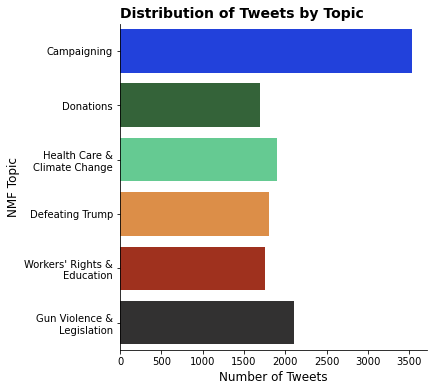

In [53]:
# Plotting the distribution of tweets by topic
colors = ["#032dfa", "#2c6b33", "#54db90", "#f48d30", "#b42209", "#323131"]
fig, ax = plt.subplots(figsize = (5.5,6))
fig.patch.set_facecolor('white')
sns.countplot(y='NMFtopic', data=topicDF, palette=colors, ax=ax)
ax.set_xlabel('Number of Tweets', fontsize = 12)
ax.set_yticklabels(('Campaigning', 'Donations',
                    'Health Care &\nClimate Change', 'Defeating Trump', 
                    "Workers' Rights &\nEducation", 'Gun Violence &\nLegislation'))
ax.set_ylabel('NMF Topic', fontsize = 12)
ax.set_title("Distribution of Tweets by Topic", 
             loc = 'left', fontweight = 'semibold', fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

A lot of the tweets were in the general campaigning and donations topics, which makes sense for candidates' Twitter accounts. Otherwise, the candidates overall were about equally-focused on health care/climate change, defeating Trump, and workers' rights/education. There were more tweets in the gun violence/legislation topic than the previous three, which was probably driven by the mass shootings in El Paso, Dayton, and elsewhere.

#### Candidates' Tweets by Topic

In [14]:
# Setting up a dataframe where the index is the candidates, each NMF topic is a column, and the values are counts
authorDF = (topicDF.loc[:,['UserName', 'NMFtopic']]
            .groupby(['UserName', 'NMFtopic'])['UserName']
            .count()
            .unstack('NMFtopic'))

# Setting up a normalized dataframe for percents of a candidate's tweets in each topic
# (first line is just reordering the columns to match previous graph)
perDF = (authorDF[['Campaigning','Donations','HealthCare_ClimateChange',
                   'Trump','WorkersRights_Education','GunViolence_Legislation']]
         .apply(lambda x: x*100/sum(x), axis=1))

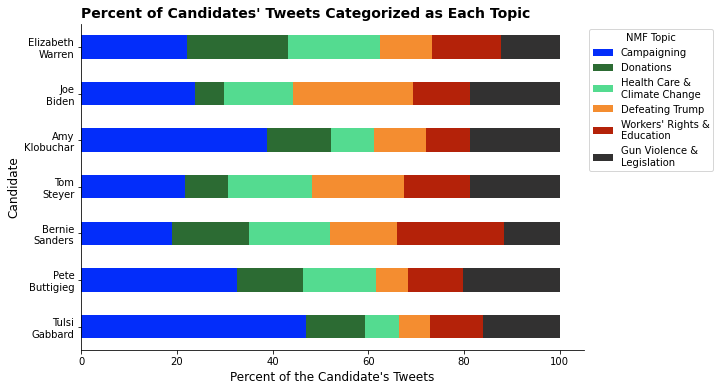

In [41]:
# Plotting percent of candidates' tweets by topic
fig, ax = plt.subplots(figsize = (9,6))
fig.patch.set_facecolor('white')
perDF.reindex(candidate_order).plot(kind='barh', stacked=True, ax=ax, color=colors)
plt.legend(labels = ['Campaigning', 'Donations',
                      'Health Care &\nClimate Change', 'Defeating Trump', 
                      "Workers' Rights &\nEducation", 'Gun Violence &\nLegislation'],
           title = "NMF Topic",
           bbox_to_anchor=(1,1))
#ax.get_legend().remove()
ax.invert_yaxis()
ax.set_xlabel("Percent of the Candidate's Tweets", fontsize = 12)
ax.set_ylabel('Candidate', fontsize = 12)
ax.set_yticklabels(('Elizabeth\nWarren', 'Joe\nBiden',
                    'Amy\nKlobuchar', 'Tom\nSteyer',
                    'Bernie\nSanders', 'Pete\nButtigieg',
                    'Tulsi\nGabbard'))
ax.set_title("Percent of Candidates' Tweets Categorized as Each Topic", 
             loc = 'left', fontweight = 'semibold', fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Some Insights:
- Biden and Steyer had proportionally more 'Defeating Trump' tweets
- Sanders had proportionally more 'Worker's Rights/Education' tweets
- Gabbard and Klobuchar had more 'Campaigning' tweets and less 'Health Care/Climate Change' tweets than the rest of the candidates, who were more even